In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import pickle as pickle
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.parametric_coupling as pmc
import analysis.plotting as plotting
import analysis.analysis as analysis

In [2]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")

Qubit(ro_amp=1, qubit_id=q1, RO_LO_pwr=16, ro_dur=4000, ef_amp=0.5, IQ_angle=205, RO_LO=6.6247, ge_amp=0.5, RO_IF=None, ro_freq=6.72745, ef_ssm=-0.259, ROIF=0.10275000000000034, qubit_thr=[-10000, -600], ge_time=66.03760771016148, ef_time=74.1982640369346, ge_ssm=-0.1145)
Qubit(ro_amp=1.5, qubit_id=q2, RO_LO_pwr=16, ro_dur=4000, ef_amp=1, IQ_angle=85, RO_LO=6.6247, ge_amp=0.5, RO_IF=None, ro_freq=6.6556, ef_ssm=-0.2962, ROIF=0.030899999999999928, qubit_thr=[-10000, 1900], ge_time=45.047198597262124, ef_time=None, ge_ssm=-0.154)


In [3]:
general_vals_dict['wx_offs'] =[0.7, 0, -0.08, 0]


In [4]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [5]:
def swap_gate_sweep(freq_list, reps,sweep_time, filename="swap_gate_sweep.pkl"):
    """
    Run a swap gate sweep by performing parametric coupling experiments at each frequency.
    Save results to a file after each step. If the file already exists, restart from the last completed step.
    """
    num_steps = 101  # Number of time steps for the parametric coupling experiment

    # Initialize arrays to store results
    I1_data = np.zeros((len(freq_list),  num_steps))
    Q1_data = np.zeros((len(freq_list), num_steps))
    I2_data = np.zeros((len(freq_list),  num_steps))
    Q2_data = np.zeros((len(freq_list), num_steps))

    # Check if the file exists
    if os.path.exists(filename):
        print(f"Loading existing data from {filename}...")
        with open(filename, "rb") as f:
            saved_data = pickle.load(f)

        # Load saved data
        I1_data = saved_data["I1_data"]
        Q1_data = saved_data["Q1_data"]
        I2_data = saved_data["I2_data"]
        Q2_data = saved_data["Q2_data"]
        last_completed_step = saved_data["last_completed_step"]

        print(f"Resuming from step {last_completed_step + 1}/{len(freq_list)}")
    else:
        last_completed_step = -1  # Start from the beginning

    # Run the sweep
    for i in range(last_completed_step + 1, len(freq_list)):
        frequency = freq_list[i]

        # Perform parametric coupling experiment
        pmc.parametric_coupling_time_domain(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            ssm_para=frequency,
            spec_amp=1.25,
            sweep_time=sweep_time,
            verbose=False,
        )
        wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
        # Acquire the raw IQ data
        values = daq.run_daq_het_2q(
            q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
        )

        # Retrieve raw IQ data from the acquired values
        # I1_raw = values.rec_readout_1[0][:reps * num_steps]
        # Q1_raw = values.rec_readout_1[1][:reps * num_steps]
        # I2_raw = values.rec_readout_2[0][:reps * num_steps]
        # Q2_raw = values.rec_readout_2[1][:reps * num_steps]
        I1_raw = values.rec_avg_vs_pats_1[0]
        Q1_raw = values.rec_avg_vs_pats_1[1]
        I2_raw = values.rec_avg_vs_pats_2[0]
        Q2_raw = values.rec_avg_vs_pats_2[1]

        # Store results
        I1_data[i] = I1_raw
        Q1_data[i] = Q1_raw
        I2_data[i] = I2_raw
        Q2_data[i] = Q2_raw

        # Save results to file after each step
        with open(filename, "wb") as f: 
            pickle.dump(
                {
                    "freq_list": freq_list,
                    "I1_data": I1_data,
                    "Q1_data": Q1_data,
                    "I2_data": I2_data,
                    "Q2_data": Q2_data,
                    "last_completed_step": i,  # Track the last completed step
                },
                f,
            )

        print(f"------------- Done with {i+1}/{len(freq_list)} --------------------")

    return I1_data, Q1_data, I2_data, Q2_data

In [6]:
freq_list = np.linspace(-0.0185, -0.0205, 21)
sweep_time = 500
swap_gate_sweep(freq_list, reps = 2000, sweep_time = sweep_time)

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 101
Records per pattern: 2000
Buffers per acquistion: 66
DAQ samples per pattern: 8192
0, No error
Capturing 66 buffers. Press <enter> to abort
Capture completed in 26.539599 sec
Captured 66 buffers (2.486850 buffers per sec)
Captured 202752 records (7639.603080 records per sec)
Transferred 3321888768 bytes (125167256.864980 bytes per sec)
------------- Done with 1/21 --------------------
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
load

(array([[-3019.62261801, -3113.98773958, -3122.30322901, ...,
         -3672.94849728, -3709.76762704, -3629.0697941 ],
        [-2773.16393468, -2771.11864256, -2780.91646112, ...,
         -3391.79702069, -3375.10388788, -3577.31644896],
        [-2824.64463207, -2743.61482086, -2911.24380002, ...,
         -3546.31340438, -3551.27528973, -3622.23038553],
        ...,
        [-2985.89403236, -3482.51076661, -3738.94528093, ...,
         -3331.32724258, -3403.54046224, -3984.46753525],
        [-2992.10841918, -2960.16443486, -3314.42922059, ...,
         -3479.29636845, -3327.37340426, -3703.25234848],
        [-3078.67207998, -3118.75290536, -3244.05295778, ...,
         -3520.57994867, -3482.08089478, -3557.65314325]]),
 array([[ 516.47989404,  492.97759733,  532.3100041 , ...,  102.21822214,
            7.32461524,  179.58715792],
        [ 613.97673071,  636.62984564,  582.27980603, ...,  171.74322495,
          137.86356484,   31.53785461],
        [ 607.67132127,  513.79093886

In [7]:
  # Check if the file exists
filename = 'swap_gate_sweep.pkl'
if os.path.exists(filename):
    print(f"Loading existing data from {filename}")
    with open(filename, "rb") as f:
        saved_data = pickle.load(f)

    # Load saved data
    I1_data = saved_data["I1_data"]
    Q1_data = saved_data["Q1_data"]
    I2_data = saved_data["I2_data"]
    Q2_data = saved_data["Q2_data"]
    freq_list = saved_data['freq_list']
    last_completed_step = saved_data["last_completed_step"]

Loading existing data from swap_gate_sweep.pkl


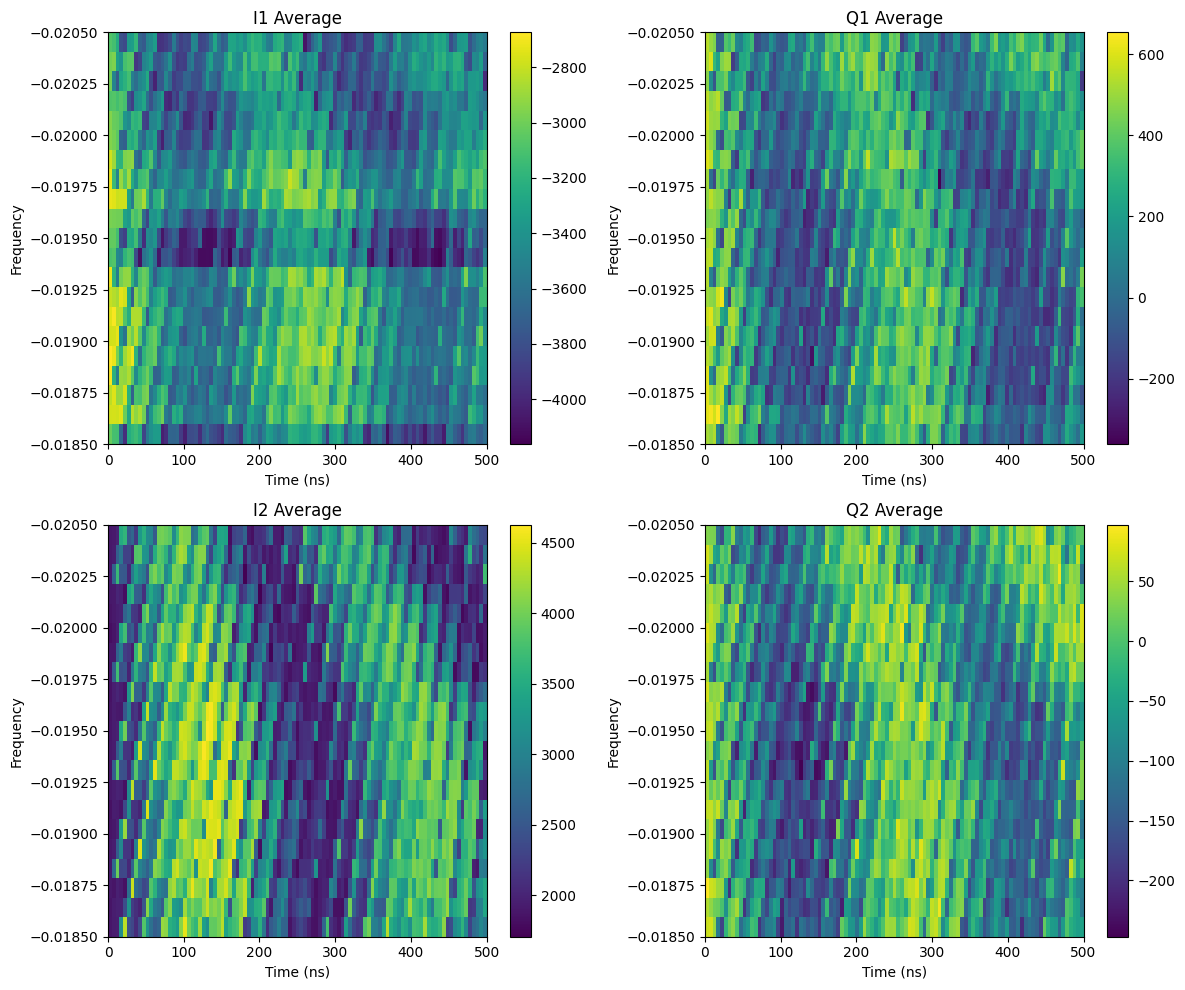

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1_data
im1 = axes[0, 0].imshow(I1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[0, 0].set_title('I1 Average')
axes[0, 0].set_xlabel('Time (ns)')
axes[0, 0].set_ylabel('Frequency')
fig.colorbar(im1, ax=axes[0, 0])

# Plot Q1_data
im2 = axes[0, 1].imshow(Q1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[0, 1].set_title('Q1 Average')
axes[0, 1].set_xlabel('Time (ns)')
axes[0, 1].set_ylabel('Frequency')
fig.colorbar(im2, ax=axes[0, 1])

# Plot I2_data
im3 = axes[1, 0].imshow(I2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[1, 0].set_title('I2 Average')
axes[1, 0].set_xlabel('Time (ns)')
axes[1, 0].set_ylabel('Frequency')
fig.colorbar(im3, ax=axes[1, 0])

# Plot Q2_data
im4 = axes[1, 1].imshow(Q2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
axes[1, 1].set_title('Q2 Average')
axes[1, 1].set_xlabel('Time (ns)')
axes[1, 1].set_ylabel('Frequency')
fig.colorbar(im4, ax=axes[1, 1])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

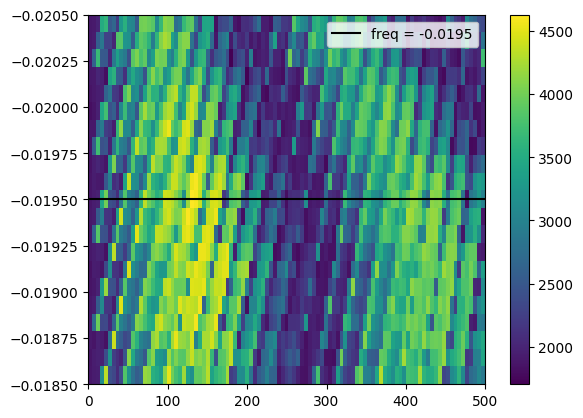

In [9]:
max_index_I2_data = np.unravel_index(np.argmax(I2_data),I2_data.shape)
plt.imshow(I2_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
plt.axhline(y=freq_list[max_index_I2_data[0]],color='black', label = f'freq = {freq_list[max_index_I2_data[0]]:.4f}')
plt.legend()
plt.colorbar()
plt.show()

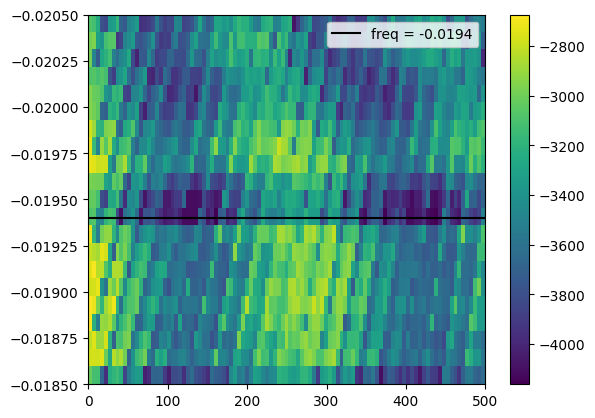

In [10]:
max_index_I1_data = np.unravel_index(np.argmin(I1_data),Q1_data.shape)
plt.imshow(I1_data, aspect='auto', extent=[0, sweep_time, freq_list[0], freq_list[-1]], origin='lower')
plt.axhline(y=freq_list[max_index_I1_data[0]],color='black', label = f'freq = {freq_list[max_index_I1_data[0]]:.4f}')
plt.legend()
plt.colorbar()
plt.show()

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 101
Records per pattern: 5000
Buffers per acquistion: 165
DAQ samples per pattern: 8192
0, No error
Capturing 165 buffers. Press <enter> to abort
Capture completed in 58.028038 sec
Captured 165 buffers (2.843453 buffers per sec)
Captured 506880 records (8735.087715 records per sec)
Transferred 8304721920 bytes (143115677.124178 bytes per sec)


<Figure size 800x800 with 0 Axes>

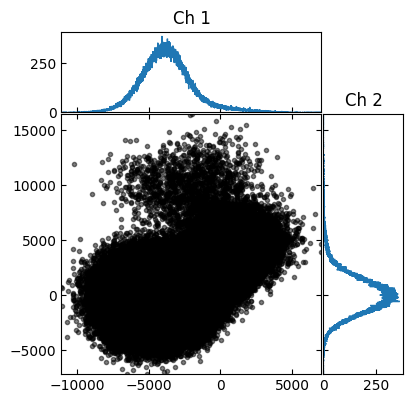

<Figure size 800x800 with 0 Axes>

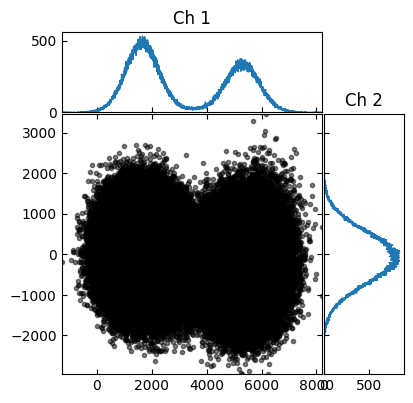

25.641025641025642


In [15]:
num_steps=101
reps=5000
frequency=-.0195
sweep_time =500#0.5*num_steps/abs(frequency)#7#500
phase = 0
spec_amp=1.25
pmc.parametric_coupling_time_domain(
            q1,
            q2,
            general_vals_dict,
            num_steps=num_steps,
            ssm_para=frequency,
            spec_amp=spec_amp,
            sweep_time=sweep_time,
            phase=phase,
            verbose=False,
        )
wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
        # Acquire the raw IQ data
values = daq.run_daq_het_2q(
            q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
        )
print(0.5*1/abs(frequency))

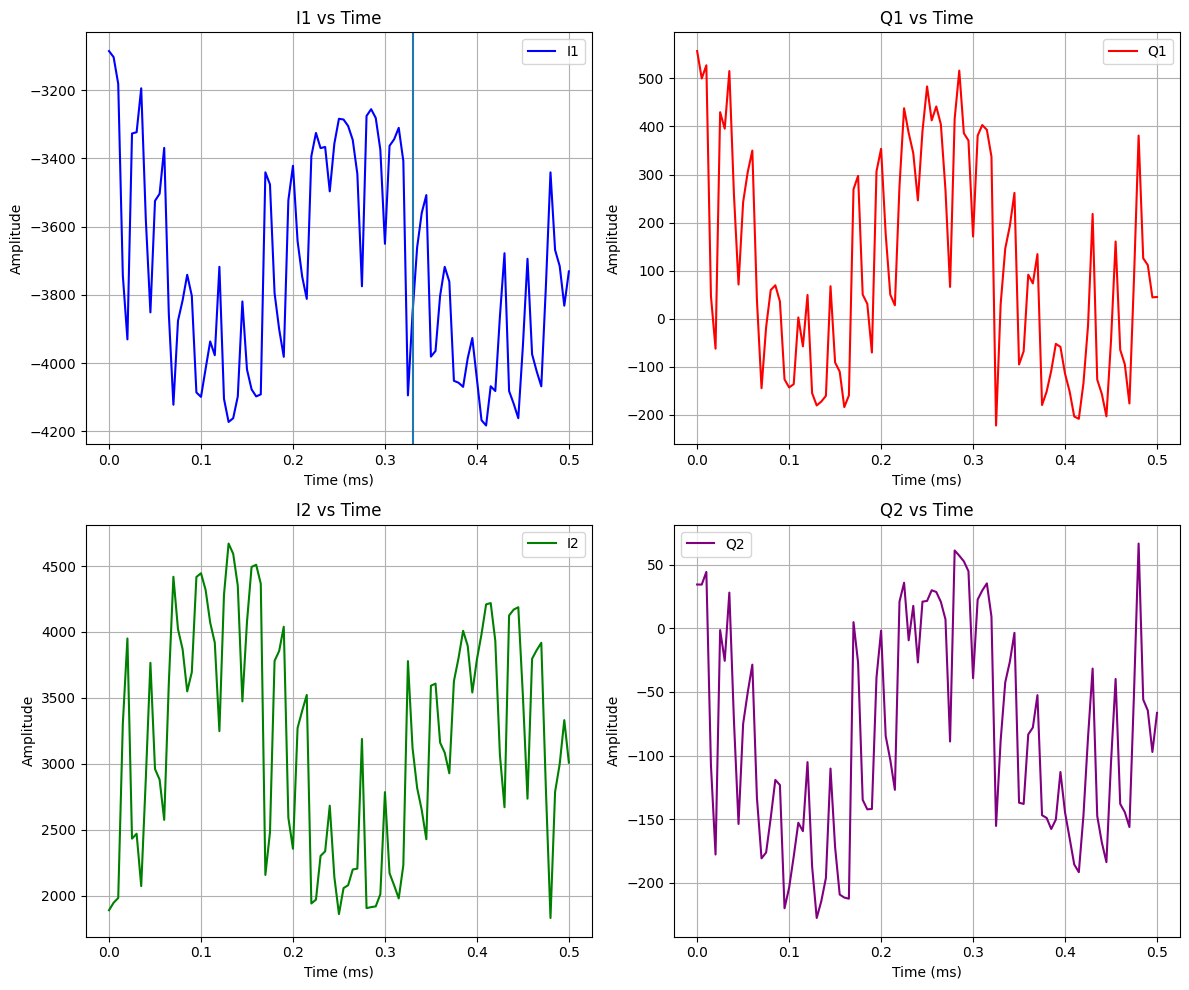

In [16]:
times = np.linspace(0, sweep_time / 1000, num_steps)  # x-axis values in milliseconds
IQ_df = plotting.get_IQ_averages(values)
# Create the 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot I1
axes[0, 0].plot(times, IQ_df['I1'], color='blue', label='I1')
axes[0, 0].set_title('I1 vs Time')
axes[0, 0].set_xlabel('Time (ms)')
axes[0, 0].set_ylabel('Amplitude')
# axes[0,0].set_xlim([0,5])
axes[0, 0].grid(True)
axes[0, 0].legend()
axes[0, 0].axvline(330/1000)

# Plot Q1
axes[0, 1].plot(times, IQ_df['Q1'], color='red', label='Q1')
axes[0, 1].set_title('Q1 vs Time')
axes[0, 1].set_xlabel('Time (ms)')
axes[0, 1].set_ylabel('Amplitude')
# axes[0,1].set_xlim([0,5])
axes[0, 1].grid(True)
axes[0, 1].legend()

# Plot I2
axes[1, 0].plot(times, IQ_df['I2'], color='green', label='I2')
axes[1, 0].set_title('I2 vs Time')
axes[1, 0].set_xlabel('Time (ms)')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].grid(True)
# axes[1,0].set_xlim([0,5])
axes[1, 0].legend()
# axes[1, 0].axvline(310/1000)

# Plot Q2
axes[1, 1].plot(times, IQ_df['Q2'], color='purple', label='Q2')
axes[1, 1].set_title('Q2 vs Time')
axes[1, 1].set_xlabel('Time (ms)')
axes[1, 1].set_ylabel('Amplitude')
# axes[1,1].set_xlim([0,5])
axes[1, 1].grid(True)
axes[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

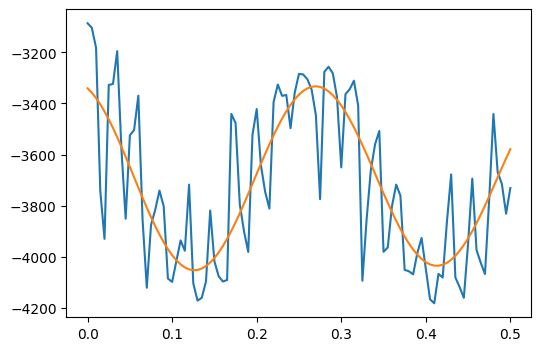



  freq: 3.4868801992363503 +/- 0.08227847817414338
 gamma: 0.1709426835530055 +/- 0.5862500737753195
   amp: 372.642107282833 +/- 59.94454218082763
 phase: 111.05053285416712 +/- 8.529839445315524
offset: -3688.542799990003 +/- 20.75578921057857
pi_pulse time: 0.14339465981925714 +/- 0.08227847817414338
π_ge time = 143.39465981925713 ns


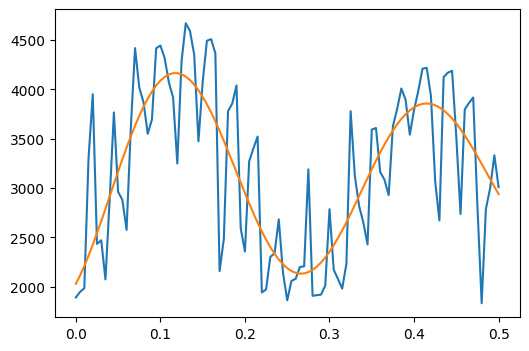



  freq: 3.3654899032014103 +/- 0.08700939570221847
 gamma: 1.1089346931722646 +/- 0.6339667066957643
   amp: -1255.9267577471 +/- 199.41572747243686
 phase: 124.36814220849384 +/- 7.701692439854052
offset: 3065.601390848277 +/- 58.629834314490715
pi_pulse time: 0.1485667805820415 +/- 0.08700939570221847
π_ge time = 148.5667805820415 ns


In [17]:
IQ_df = plotting.get_IQ_averages(values)
I1 = IQ_df['I1']
I2 = IQ_df['I2']
Q1 = IQ_df['Q1']
Q2= IQ_df['Q2']

Qrange1 = abs(np.max(Q1)-np.min(Q1))
Irange1 = abs(np.max(I1)-np.min(I1))
if Qrange1>Irange1:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q1,guess_vals=[5,2,np.abs(np.max(Q1)-np.min(Q1)),38,Q1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I1,guess_vals=[5,2,np.abs(np.max(I1)-np.min(I1)),38,I1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
Qrange2 = abs(np.max(Q2)-np.min(Q2))
Irange2 = abs(np.max(I2)-np.min(I2))
if Qrange2>Irange2:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q2,guess_vals=[5,2,np.abs(np.max(Q2)-np.min(Q2)),38,Q1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I2,guess_vals=[5,2,np.abs(np.max(I2)-np.min(I2)),38,I1[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))

In [28]:
time_fixed=6*0.5*1/abs(frequency)
amp_start=1.1
amp_stop=1.3
amp_steps=21
num_steps=3
reps=15000
frequency=-.0195
I1=np.zeros(amp_steps)
I2=np.zeros(amp_steps)
amp=np.linspace(amp_start,amp_stop,amp_steps)
for i in range(len(amp)):    
    spec_amp=amp[i]
    pmc.parametric_coupling_time_domain(
                q1,
                q2,
                general_vals_dict,
                num_steps=num_steps,
                ssm_para=frequency,
                spec_amp=spec_amp,
                sweep_time=time_fixed,
                phase=phase,
                verbose=False,
            )
    wx.wx_set_and_amplitude_and_offset(
            amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
        )
            # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
                q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
            )
    IQ_df = plotting.get_IQ_averages(values)
    I1[i] = IQ_df['I1'][2]
    I2[i] = IQ_df['I2'][2]


    

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 3
Records per pattern: 15000
Buffers per acquistion: 15
DAQ samples per pattern: 8192
0, No error
Capturing 15 buffers. Press <enter> to abort
Capture completed in 6.225308 sec
Captured 15 buffers (2.409519 buffers per sec)
Captured 46080 records (7402.043187 records per sec)
Transferred 754974720 bytes (121275075.576667 bytes per sec)
writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 3
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0,

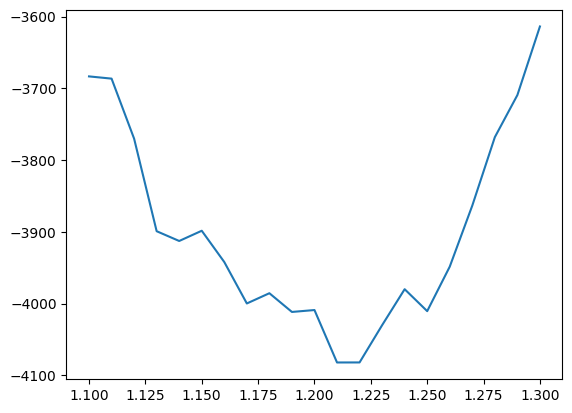

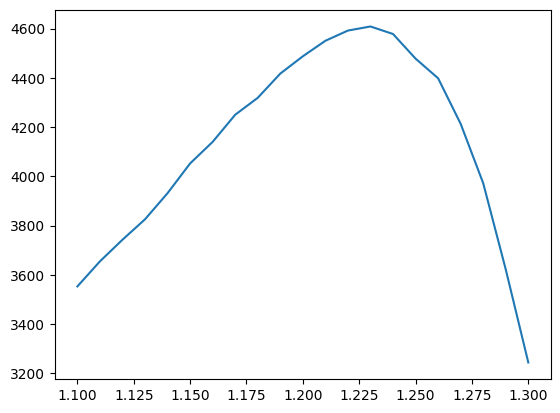

1.23


In [29]:
plt.plot(amp,I1)
plt.show()
plt.plot(amp,I2)
plt.show()
max_index_I2 = np.unravel_index(np.argmax(I2),I2.shape)
print(amp[max_index_I2[0]])
